In [1]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/Deep Learning/dog-breed-identification/dog-breed-identification.zip" -d "drive/MyDrive/Colab Notebooks/Deep Learning/dog-breed-identification/dog-breed-data/"

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras
from sklearn.model_selection import train_test_split
from typing import List, Union

In [2]:
print("Tensorflow Verions: {}\nHub version : {},\nGPU : {}".format(tf.__version__,hub.__version__,tf.config.list_physical_devices('GPU')))

Tensorflow Verions: 2.18.0
Hub version : 0.16.1,
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load data

In [4]:
def load_dataset_and_map_breed_idx(file_name: str) -> Union[pd.DataFrame, List]:

    dataset_df = pd.read_csv(file_name)
    unique_breeds = sorted(dataset_df["breed"].unique().tolist())
    map_breed_idx = {breed: idx for idx, breed in enumerate(unique_breeds)}
    dataset_df["breed_idx"] = dataset_df["breed"].map(map_breed_idx)

    return dataset_df, unique_breeds

In [5]:
common_path = "drive/MyDrive/Colab Notebooks/Deep Learning/dog-breed-identification/"
labels_path = os.path.join(common_path, "dog-breed-data/labels.csv")
dataset_df, unique_breeds = load_dataset_and_map_breed_idx(labels_path)

In [6]:
train_df, val_tf = train_test_split(dataset_df, test_size=0.2, stratify=dataset_df["breed_idx"], random_state=42)

#### Create tensordata

In [7]:
def create_tensor_slices(dataset: pd.DataFrame) -> tf.data.Dataset:
    image_path_hash = dataset["id"].values
    breed_idx = dataset["breed_idx"].values

    return tf.data.Dataset.from_tensor_slices((image_path_hash, breed_idx))

In [8]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

train_tensor_data = create_tensor_slices(train_df)  # Raw data is filled
val_tensor_data = create_tensor_slices(val_tf)

#### Fill tensordata with images

In [9]:
image_folder_path = os.path.join(common_path, "dog-breed-data/train")
IMAGE_FOLDER = image_folder_path
IMAGE_SIZE = (224, 224)

def load_image_in_tensor(image_id:str, label:str):
    image_path = tf.strings.join([IMAGE_FOLDER, "/", image_id, ".jpg"])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0

    return image, label

In [10]:
train_tensor_data = train_tensor_data.map(load_image_in_tensor, num_parallel_calls=tf.data.AUTOTUNE)  # Actual images are loaded
val_tensor_data = val_tensor_data.map(load_image_in_tensor, num_parallel_calls=tf.data.AUTOTUNE)

#### Shuffle and batch the data

In [11]:
BATCH_SIZE = 32

train_tensor_data = train_tensor_data.shuffle(buffer_size=1000)
val_tensor_data = val_tensor_data.shuffle(buffer_size=1000)
train_tensor_data = train_tensor_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_tensor_data = val_tensor_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### Create model

In [12]:
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4"

def create_model(MODEL_URL: str, units: int):
    feature_extractor_layer = hub.KerasLayer(MODEL_URL, input_shape=(224, 224, 3), trainable=False)  # freeze weights
    model = tf_keras.Sequential([feature_extractor_layer, tf_keras.layers.Dense(units=units, activation="softmax")])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

In [13]:
model = create_model(MODEL_URL=MODEL_URL, units=len(unique_breeds))

#### Load the model with train and validation data

In [14]:
trained_model = model.fit(train_tensor_data, validation_data=val_tensor_data, epochs=10)

Epoch 1/10
256/256 [==============================] - 352s 1s/step - loss: 1.4201 - accuracy: 0.6523 - val_loss: 0.7140 - val_accuracy: 0.7848
Epoch 2/10
256/256 [==============================] - 14s 51ms/step - loss: 0.3797 - accuracy: 0.8901 - val_loss: 0.6556 - val_accuracy: 0.7995
Epoch 3/10
256/256 [==============================] - 14s 50ms/step - loss: 0.2121 - accuracy: 0.9463 - val_loss: 0.6597 - val_accuracy: 0.7961
Epoch 4/10
256/256 [==============================] - 14s 51ms/step - loss: 0.1287 - accuracy: 0.9762 - val_loss: 0.6651 - val_accuracy: 0.7956
Epoch 5/10
256/256 [==============================] - 14s 51ms/step - loss: 0.0873 - accuracy: 0.9864 - val_loss: 0.6742 - val_accuracy: 0.8029
Epoch 6/10
256/256 [==============================] - 14s 51ms/step - loss: 0.0603 - accuracy: 0.9944 - val_loss: 0.6860 - val_accuracy: 0.7966
Epoch 7/10
256/256 [==============================] - 14s 51ms/step - loss: 0.0464 - accuracy: 0.9963 - val_loss: 0.6928 - val_accuracy: 

In [15]:
def plot_acurracy(stats):
    epochs = range(1, len(stats['loss']) + 1)


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, stats["accuracy"], label = "Train accuracy")
    plt.plot(epochs, stats["val_accuracy"], label = "Val accuracy")
    plt.legend(loc='upper right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, stats["loss"], label = "Train Loss")
    plt.plot(epochs, stats["val_loss"], label = "Val Loss")
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.show()


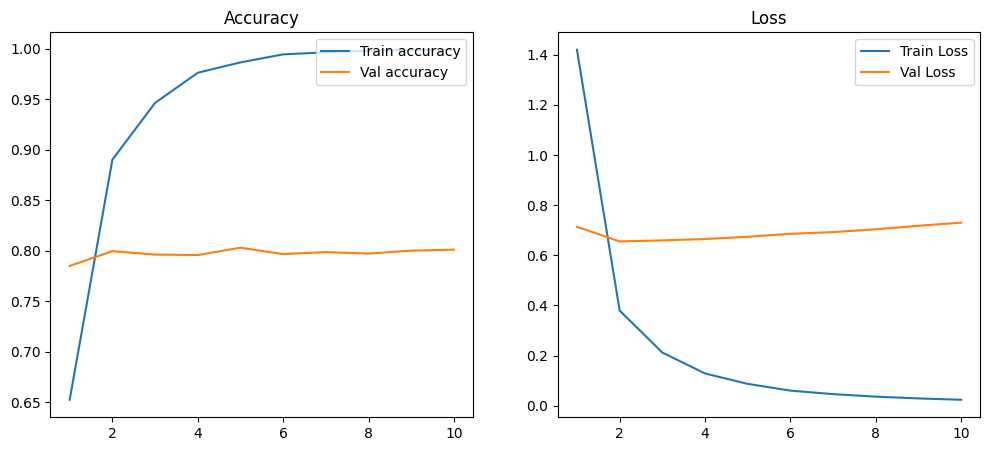

In [16]:
plot_acurracy(trained_model.history)

#### Save the model

In [17]:
model_save_path = os.path.join(common_path, "models/dog_breed_identification2.keras")
model.save(model_save_path)

In [18]:
loaded_model = tf_keras.models.load_model(model_save_path,custom_objects={"KerasLayer": hub.KerasLayer})

In [19]:
def preprocess_prediction_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)
    return image


def predict_dog_breed(image_path):
    processed_image = preprocess_prediction_image(image_path)
    predictions = loaded_model.predict(processed_image)
    predictions = predictions[0]

    predictions_idx = np.argsort(predictions)

    top_5_idx = predictions_idx[-5:][::-1] # Select last 5 predicts and sort by desc
    top_5_breeds = [ unique_breeds[i] for i in top_5_idx ]

    top_5_scores = predictions[top_5_idx]
    top_5_scores = [f"{i * 100:.2f}%"  for i in top_5_scores ]


    final_predictions = pd.DataFrame({"breed":top_5_breeds,"score":top_5_scores})


    return final_predictions


In [21]:
to_be_predicted_image_path = os.path.join(common_path, "dog-breed-data/test/8e6a11df866b85cfb0f921b7947ae77d.jpg")

my_predictions = predict_dog_breed(to_be_predicted_image_path)

1/1 [==============================] - 1s 657ms/step


In [22]:
my_predictions

,breed,score
0,english_foxhound,81.49%
1,walker_hound,9.12%
2,brittany_spaniel,6.21%
3,wire-haired_fox_terrier,2.88%
4,toy_terrier,0.11%
